# Simulate photonic lantern spectra

This notebook explains how to simulate photonic lantern's spectrum for given astronomical scenes.

### 1. Set up the mode-sorting device

First import necessary modules

In [1]:
from PLsim.otf import OTF
from PLsim.scene import Scene, SceneProjector
from PLsim.system.device import Device

import hcipy as hc
import numpy as np
import matplotlib.pyplot as plt

For the mode-sorting device, we will use a 6-port photonic lantern. To set up the OTF matrix we can use `OTF.from_fiber_params` class method, which takes pupil grid, focal grid, and fiber parameters as inputs. Below are the parameters to set up a 6-port lantern.

In [2]:
# Define pupil grid
ndim = 65 # this is enough for a 6-port PL
diameter = 10 # meters
pupil_grid = hc.make_pupil_grid(ndim, diameter)
ref_wavelength = 1.55e-6 # meters

# Define focal grid 
focal_plane_resolution = 1e-6 # meters. Make sure this samples LP modes enough but also not truncate the outer parts.
focal_length = 40 # meters (just an initial value. OTF.from_fiber_params will find an optimal focal ratio)
focal_grid = hc.make_pupil_grid(ndim, focal_plane_resolution * ndim)

# Define PL multimode entrance parameters (changing this would change the number of guided modes)
ncore = 1.444
nclad = 1.444 - 5.5e-3
rcore = 10e-6 # meters

# Telescope aperture (circular)
aperture = hc.make_circular_aperture(diameter)(pupil_grid)

In [3]:
otf = OTF.from_fiber_params(ncore, nclad, rcore, ref_wavelength,
                            focal_grid, pupil_grid, focal_length,
                            aperture, optimize_focal_length = False)

Supported modes:  ['LP01', 'LP11a', 'LP11b', 'LP21a', 'LP21b', 'LP02']
Number of modes:  6


Now let's show how the focal-plane modes look like.

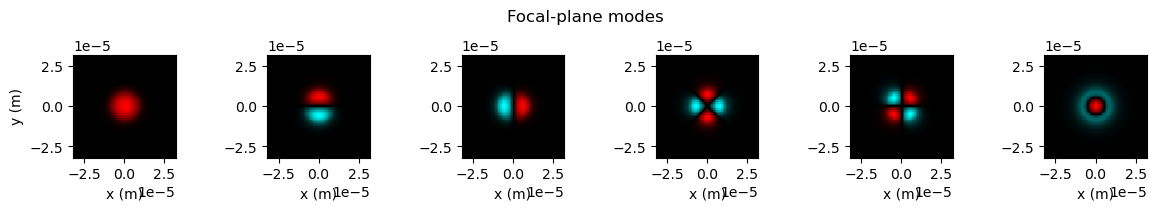

In [4]:
fig, axs = plt.subplots(ncols=6, figsize=(12,2))
for i in range(6):
    hc.imshow_field(otf.focal_modes[i], grid = focal_grid, ax=axs[i])
    axs[i].set_xlabel('x (m)')
fig.suptitle('Focal-plane modes')
axs[0].set_ylabel('y (m)')
fig.tight_layout()
plt.show()

This looks good (modes not out of the focal grid, also good enough sampling).

Now do `otf.compute()` to compute the OTF matrix.
Note that if the `ndim` is too large or the number of modes is big, this computation may be slow.

In [5]:
otf.compute()

Now set up the `Device` with a transfer matrix.

Let's assume 21 wavelength channels for our simulation.
The transfer matrix should have the dimension of (nwav X n_outputs X n_modes).

We will assume here a very narrow bandwidth, so that transfer matrix does not change with wavelength.

In [6]:
from PLsim.system.lantern import generate_unitary_matrix

nwav = 21
matrix  = generate_unitary_matrix(6)[np.newaxis,:,:].repeat(nwav, axis=0)

In [7]:
from PLsim.system.device import Device
device = Device(matrix)

Device initialized with:
  Lantern matrices: (21, 6, 6)
  PIC matrices: None
  Wavelengths: 21


### 2. Make the input scene

Define the `Scene` object to calculate mutual coherence functions, and the `SceneProjector` object that projects the mutual coherence functions onto the OTFs.

In [8]:
scene = Scene(pupil_grid, ref_wavelength)
scene_projector = SceneProjector(otf, scene)

Make an input scenes as a function of wavelength. Let's say we have binary stars, with one star having deep absorption line.

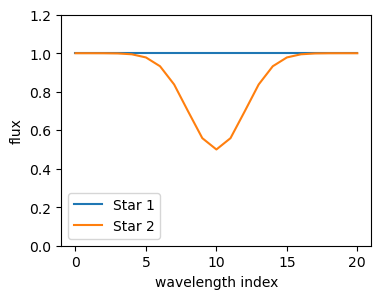

In [9]:
wavelength_inds = np.arange(nwav)

star1_spectrum = np.ones(nwav)
star2_spectrum = np.ones(nwav)

central_wavelength = nwav // 2
line_width = 2

star2_spectrum -= 0.5* np.exp(-0.5 * (wavelength_inds - central_wavelength)**2 / (line_width)**2)

fig = plt.figure(figsize=(4,3))
plt.plot(wavelength_inds, star1_spectrum, label='Star 1')
plt.plot(wavelength_inds, star2_spectrum, label='Star 2')
plt.ylim([0,1.2])
plt.legend()
plt.xlabel('wavelength index')
plt.ylabel('flux')
plt.show()

For binaries, simply compute responses for two positions and combine them.

In [10]:
star1_x, star1_y = 0, 0 # 0 mas, 0 mas (on-axis)
star2_x, star2_y = 15e-3/206265, 0 # 15 mas, 0 mas

# calculate responses for the two positions and scale by spectra
star1_projected = scene_projector.compute_point(star1_x, star1_y).repeat(nwav, axis=2) * star1_spectrum[np.newaxis, np.newaxis]
star2_projected = scene_projector.compute_point(star2_x, star2_y).repeat(nwav, axis=2) * star2_spectrum[np.newaxis, np.newaxis]

combined = star1_projected + star2_projected

### 3. Simulate spectra

Now pass through the device!

In [12]:
# I need better treatment to avoid transpose
out_spectra = device.calculate_outputs(combined.transpose(2,0,1)) 

Plot the results

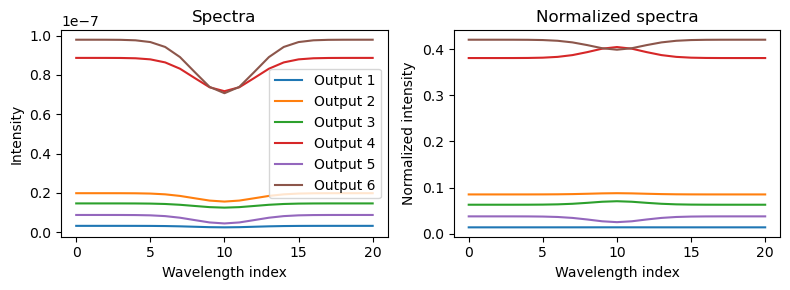

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3))
for i in range(6):
    axs[0].plot(out_spectra[:,i], label=f'Output {i+1}')
    axs[1].plot(out_spectra[:,i]/np.sum(out_spectra,axis=1))

axs[0].set_title('Spectra')
axs[1].set_title('Normalized spectra')
axs[0].set_xlabel('Wavelength index')
axs[1].set_xlabel('Wavelength index')
axs[0].set_ylabel('Intensity')
axs[1].set_ylabel('Normalized intensity')
axs[0].legend()
fig.tight_layout()
plt.show()

### 4. More complex scenes

One may want to simulate more complex scenes. For this case, it is useful to generate a 2D grid of responses, then synthesize it to simulate any image.

In [118]:
fov = 50e-3 / 206265 # radians (100 mas)
ngrid = 64 # number of grid points along one axis. Odd number to have a center point. Increasing this significantly increases computation time.
out_grid = scene_projector.compute_point_grid(fov, ngrid)

These are some functions to compute a simple Keplerian disk model.

In [167]:

def make_simple_powerlaw_disk(Vrot, Rstar, Rout, power_index, incl_angle, PA, beta = -0.5,
                              ngrid = 128, fov = 30, 
                              plot = True,
                              azimuthal_amp = 0,
                              azimuthal_zp = 0): #,
    '''
    make simple Gaussian disk model
    Assumes Gaussian intensity distribution
    and simple rotation (zero inward/outward velocity)

    args:
        Vrot: stellar rotation velocity (km/s)
        Rstar: stellar radius (mas)
        Rout: disk outer radius (mas)
        power_index: power of the power-law intensity distribution
        incl_angle: inclination angle (radians)
        PA: disk position angle (radians)
        beta: power of the rotation velocity profile (-0.5 for Keplerian)
        ngrid: resolution of the output image
        fov: field of view (diameter) of the output image (mas)
    
    returns:
        intenmap: intensity map
        velmap: velocity map
        xg: x grid in mas
        yg: y grid in mas
    '''

    # output grid
    xa = np.linspace(-fov/2, fov/2, ngrid)
    yg, xg = np.meshgrid(xa, xa, indexing = 'ij') 

    # grid in the disk cylindrical coordinates
    mat = np.array([[np.cos(PA) * np.cos(incl_angle), np.sin(PA) * np.cos(incl_angle)], [-np.sin(PA), np.cos(PA)]]) / np.cos(incl_angle)
    [xg2,yg2] = (mat @ (np.array([xg.flatten(), yg.flatten()]))) 
    xg2 = xg2.reshape((ngrid, ngrid))
    yg2 = yg2.reshape((ngrid, ngrid))

    # distance to the disk center
    rmap = np.sqrt(xg2**2 + yg2**2)
    rmask = (rmap > Rstar) & (rmap < Rout)

    # intensity map of the disk
    azimuthal_angle = np.arctan2(xg, yg)
    
    intenmap = ((rmap) /Rstar)**power_index * rmask * (1+azimuthal_amp *np.cos(azimuthal_angle + azimuthal_zp + PA)/2)
    intenmap /= np.nansum(intenmap)
    # intenmap = ((rmap * (1+azimuthal_amp *np.cos(azimuthal_angle + azimuthal_zp + PA)/2 + azimuthal_amp2 * np.cos(2*azimuthal_angle + azimuthal_zp2 + PA))) /Rout)**power_index * rmask

    # define rotation velocity profile
    def vfun(r): return Vrot * (r / Rstar)**beta

    # velocity map
    velmap = -(vfun(rmap)/rmap)* np.sin(incl_angle) * (np.cos(PA) * xg + np.sin(PA) * yg) * rmask

    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10,4))
        axs[0].imshow(intenmap, origin='lower', extent=(-fov/2, fov/2, -fov/2, fov/2))
        # axs[0].contour(intenmap, origin='lower', extent=(-fov/2, fov/2, -fov/2, fov/2),
        #                levels = [0.5], colors='white')
        p=axs[1].imshow(velmap, origin='lower', extent=(-fov/2, fov/2, -fov/2, fov/2), cmap='RdBu')
        axs[1].contour(velmap, origin='lower', extent=(-fov/2, fov/2, -fov/2, fov/2),
                       colors='black',linestyles='--', alpha=0.3,
                       levels=[0])
        plt.colorbar(p, ax=axs[1])
        
        axs[0].set_title('Intensity map')
        axs[1].set_title('Velocity map')

        for ax in axs:
            ax.set_xlabel('x (mas)')
            ax.set_ylabel('y (mas)')
    return intenmap, velmap, xg, yg


def get_iso_velocity_map(intenmap, velmap, vgrid, vsig = None):
    '''
    makes iso-velocity maps given intensity map, velocity map, and velocity grid
    this only works with regular velocity grid
    '''

    # assert np.all(np.isclose(np.diff(vgrid), np.diff(vgrid)[0])), "only supports regular velocity grid!"
    
    if vsig is None:
        dv = np.abs(np.diff(vgrid)[0])
        vsig = dv / (2*np.sqrt(2*np.log(2)))

    iso_maps = []
    for v in vgrid:
        iso_maps.append(intenmap * (1/vsig/np.sqrt(2*np.pi))*np.exp(-(velmap - v)**2 / 2 / vsig**2))

    return np.array(iso_maps)


def make_star(xg, yg, Rstar, theta, ratio):
    xg_rot = xg * np.cos(theta) - yg * np.sin(theta)
    yg_rot = xg * np.sin(theta) + yg * np.cos(theta)
    star = xg_rot**2 + (yg_rot / np.sqrt(ratio))**2 <= Rstar**2
    # star = yg_rot**2 + (xg_rot / np.sqrt(ratio))**2 <= Rstar**2
    star = star.astype(float)
    star /= np.sum(star)  # normalize the star
    return star

Let's create a scene with central star (assumed uniform disk and flat spectrum) and a Keplerian disk emitting emission line.

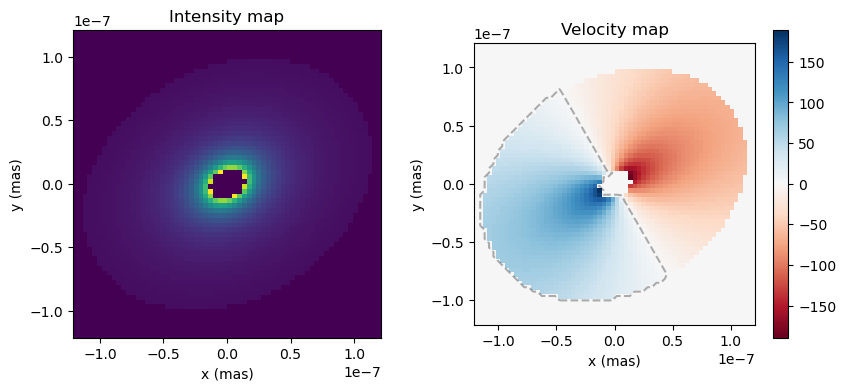

In [168]:
Vrot = 300
Rstar = 3e-3/206265
Rout = 2.5*10e-3/206265
power_index = -1.6
incl_angle = np.radians(40)
PA = np.radians(30)
beta = -0.5
ngrid = 64

intenmap, velmap, xg, yg = make_simple_powerlaw_disk(
                                 Vrot,
                                 Rstar = Rstar,
                                 Rout = Rout,
                                 power_index = power_index,
                                 incl_angle = incl_angle,
                                 PA = PA,
                                 beta = beta,
                                 ngrid = ngrid,
                                 fov = fov,
                                    plot = True)

star = make_star(xg, yg, Rstar, -PA, np.cos(incl_angle))

vgrid = np.linspace(-300, 300, nwav) # km/s
vsig = 20 # km/s
isomap = get_iso_velocity_map(intenmap, velmap, vgrid, vsig)

star_frac = 3e-3

In [169]:
# synthesize the two images
images = isomap + star * star_frac

This is how the images look like

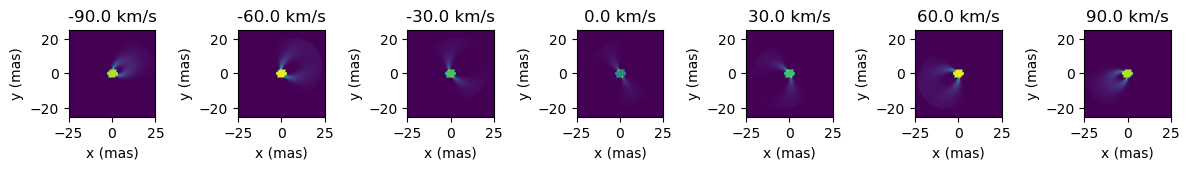

In [166]:
show_indices = np.arange(10-3, 10+4, 1)
fig, axs = plt.subplots(ncols=len(show_indices), figsize=(12,3))
for i, ind in enumerate(show_indices):
    axs[i].imshow(images[ind], origin='lower', extent=(-fov/2*206265e3, fov/2*206265e3, -fov/2*206265e3, fov/2*206265e3))
    axs[i].set_title(f'{vgrid[ind]:.1f} km/s')
    axs[i].set_xlabel('x (mas)')
    axs[i].set_ylabel('y (mas)')
fig.tight_layout()
plt.show()

Simulate the spectra

In [161]:
disk_outs = np.zeros((nwav, 6))
for wavind in wavelength_inds:
    disk_outs[wavind] = (device.calculate_outputs(scene_projector.compute_scene_from_image(images[wavind]))[wavind])

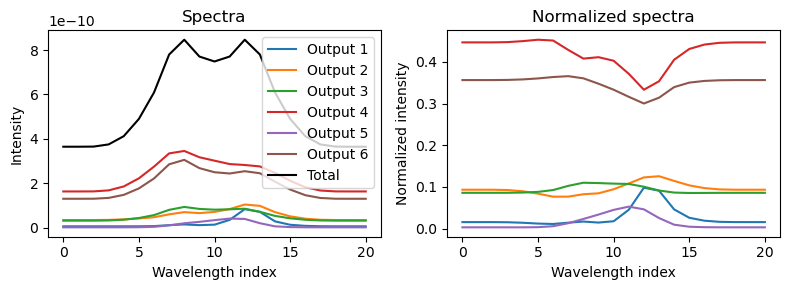

In [172]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3))
for i in range(6):
    axs[0].plot(disk_outs[:,i], label=f'Output {i+1}')
    axs[1].plot(disk_outs[:,i]/np.sum(disk_outs,axis=1))

axs[0].plot(np.sum(disk_outs, axis=1), label='Total', color='k')
axs[0].set_title('Spectra')
axs[1].set_title('Normalized spectra')
axs[0].set_xlabel('Wavelength index')
axs[1].set_xlabel('Wavelength index')
axs[0].set_ylabel('Intensity')
axs[1].set_ylabel('Normalized intensity')
axs[0].legend()
fig.tight_layout()
plt.show()